## Assignment 3: Pattern Mining and Recommender Systems

### Task 2: Collaborative Filtering
### Lalitphan Sae-teoh, a1932456, Version 04

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import implicit
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [2]:
df = pd.read_csv('./data/Groceries data train.csv')
df.dropna(subset=["User_id"], inplace=True)
df = df.astype({'User_id': 'int', 'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int'})
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce').dt.date
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,User_id,itemDescription,year,month,day,day_of_week
Date,,,,,,
2014-01-01,2351,cleaner,2014,1,1,2
2014-01-01,2226,sausage,2014,1,1,2
2014-01-01,1922,tropical fruit,2014,1,1,2
2014-01-01,2943,whole milk,2014,1,1,2
2014-01-01,1249,citrus fruit,2014,1,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 2014-01-01 to 2015-01-20
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19382 non-null  int32 
 1   itemDescription  19382 non-null  object
 2   year             19382 non-null  int32 
 3   month            19382 non-null  int32 
 4   day              19382 non-null  int32 
 5   day_of_week      19382 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 681.4+ KB


In [4]:
df_test = pd.read_csv('./data/Groceries data test.csv')
df_test.rename(columns={"user_id": "User_id"}, inplace=True)
df_test.dropna(subset=["User_id"], inplace=True)
df_test = df_test.astype({'User_id': 'int', 'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int'})
df_test['Date'] = pd.to_datetime(df_test['Date'], dayfirst=True, errors='coerce').dt.date
df_test.set_index('Date', inplace=True)
df_test.sort_index(inplace=True)
df_test.head()

,User_id,itemDescription,year,month,day,day_of_week
Date,,,,,,
2015-01-20,2889,yogurt,2015,1,20,1
2015-01-20,4744,soda,2015,1,20,1
2015-01-20,2430,root vegetables,2015,1,20,1
2015-01-20,1492,other vegetables,2015,1,20,1
2015-01-20,2682,whole milk,2015,1,20,1


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19383 entries, 2015-01-20 to 2015-12-30
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19383 non-null  int32 
 1   itemDescription  19383 non-null  object
 2   year             19383 non-null  int32 
 3   month            19383 non-null  int32 
 4   day              19383 non-null  int32 
 5   day_of_week      19383 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 681.4+ KB


Import frequent items rules

In [6]:
rules = pd.read_csv('./data/rules_dummy.csv')
print(f"Total Rules: {len(rules)}")
rules

Total Rules: 32


,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,19,frozenset({'frankfurter'}),frozenset({'whole milk'}),0.012199,0.130487,0.002033,0.166667,1.277269,1.0,0.000441,1.043416,0.219760,0.014456,0.041609,0.091124
1,17,frozenset({'detergent'}),frozenset({'rolls/buns'}),0.008492,0.101902,0.001196,0.140845,1.382166,1.0,0.000331,1.045328,0.278866,0.010953,0.043362,0.076291
2,29,frozenset({'seasonal products'}),frozenset({'rolls/buns'}),0.007774,0.101902,0.001076,0.138462,1.358776,1.0,0.000284,1.042436,0.266112,0.009912,0.040708,0.074512
3,24,frozenset({'pot plants'}),frozenset({'yogurt'}),0.008372,0.078579,0.001076,0.128571,1.636204,1.0,0.000419,1.057368,0.392112,0.012535,0.054256,0.071135
4,26,frozenset({'processed cheese'}),frozenset({'rolls/buns'}),0.011482,0.101902,0.001435,0.125000,1.226673,1.0,0.000265,1.026398,0.186933,0.012821,0.025719,0.069542
5,22,frozenset({'napkins'}),frozenset({'pastry'}),0.024997,0.049635,0.002033,0.081340,1.638750,1.0,0.000793,1.034512,0.399772,0.028007,0.033360,0.061152
6,4,frozenset({'sugar'}),frozenset({'bottled water'}),0.019376,0.060758,0.001555,0.080247,1.320757,1.0,0.000378,1.021189,0.247657,0.019787,0.020749,0.052919
7,11,frozenset({'cat food'}),frozenset({'fruit/vegetable juice'}),0.014233,0.036718,0.001076,0.075630,2.059754,1.0,0.000554,1.042096,0.521934,0.021583,0.040395,0.052473
8,1,frozenset({'berries'}),frozenset({'pastry'}),0.016266,0.049635,0.001196,0.073529,1.481396,1.0,0.000389,1.025791,0.330334,0.018484,0.025142,0.048813
9,31,frozenset({'sliced cheese'}),frozenset({'root vegetables'}),0.014711,0.060399,0.001076,0.073171,1.211447,1.0,0.000188,1.013780,0.177147,0.014540,0.013592,0.045496


In [7]:
def to_frozenset(x):
    clean_x = x.split("{")[1].split("}")[0].replace("'", "").split(",")
    return frozenset(clean_x)

rules["antecedents"] = rules["antecedents"].apply(to_frozenset)
rules["consequents"] = rules["consequents"].apply(to_frozenset)
rules.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,19,(frankfurter),(whole milk),0.012199,0.130487,0.002033,0.166667,1.277269,1.0,0.000441,1.043416,0.219760,0.014456,0.041609,0.091124
1,17,(detergent),(rolls/buns),0.008492,0.101902,0.001196,0.140845,1.382166,1.0,0.000331,1.045328,0.278866,0.010953,0.043362,0.076291
2,29,(seasonal products),(rolls/buns),0.007774,0.101902,0.001076,0.138462,1.358776,1.0,0.000284,1.042436,0.266112,0.009912,0.040708,0.074512
3,24,(pot plants),(yogurt),0.008372,0.078579,0.001076,0.128571,1.636204,1.0,0.000419,1.057368,0.392112,0.012535,0.054256,0.071135
4,26,(processed cheese),(rolls/buns),0.011482,0.101902,0.001435,0.125000,1.226673,1.0,0.000265,1.026398,0.186933,0.012821,0.025719,0.069542


### Data Analysis

In [8]:

min_date = df.index.min()
max_date = df.index.max()
test_min_date = df_test.index.min()
test_max_date = df_test.index.max()

print("Train Dataset")
print("------------------------------------")
print(f"Total records: {len(df)}")
print("Minimum date:", min_date)
print("Maximum date:", max_date)
print("====================================")

print("Test Dataset")
print("------------------------------------")
print(f"Total records: {len(df_test)}")
print("Minimum date:", test_min_date)
print("Maximum date:", test_max_date)

Train Dataset
------------------------------------
Total records: 19382
Minimum date: 2014-01-01
Maximum date: 2015-01-20
Test Dataset
------------------------------------
Total records: 19383
Minimum date: 2015-01-20
Maximum date: 2015-12-30


In [9]:
users = df['User_id'].unique()
print("Total Train Users:", len(users))

test_users = df_test['User_id'].unique()
print("Total Test Users:", len(test_users))

set_train_users = set(users)
set_test_users = set(test_users)
all_users = set_train_users.union(set_test_users)

print(f"Total Unique Users in all data set: {len(all_users)}")

new_users_test_set = set_test_users.difference(set_train_users)
print(f"New users in test data set: {len(new_users_test_set)}")
print(f"Example of new test users: {list(new_users_test_set)[:5]}")

Total Train Users: 3493
Total Test Users: 3231
Total Unique Users in all data set: 3898
New users in test data set: 405
Example of new test users: [4102, 2061, 4118, 2073, 4141]


In [10]:
items = df['itemDescription'].unique()
test_items = df_test['itemDescription'].unique()
print("Total Items:", len(items))
print("Total Test Items:", len(test_items))

set_train_items = set(items)
set_test_items = set(test_items)
all_items = set_train_items.union(set_test_items)

print(f"Total Unique Users in all data set: {len(all_items)}")

new_items_test_set = set_test_items.difference(set_train_items)
print(f"New items in test data set: {len(new_items_test_set)}")

Total Items: 167
Total Test Items: 164
Total Unique Users in all data set: 167
New items in test data set: 0


Visualization of Top 20 items

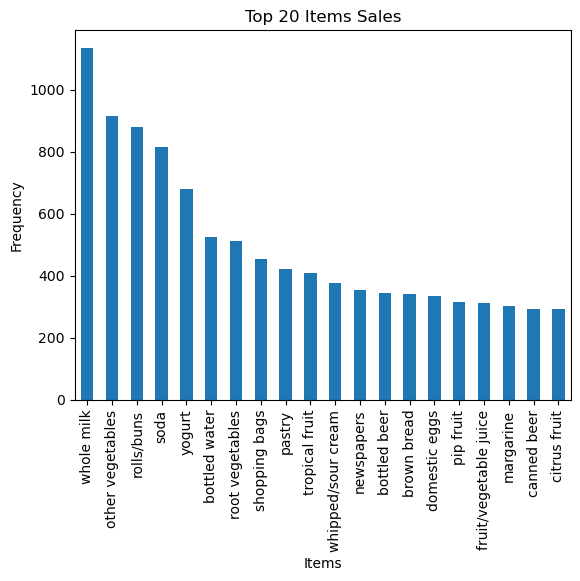

In [11]:
item_counts = df['itemDescription'].value_counts()[:20]

item_counts.plot.bar()
plt.title('Top 20 Items Sales')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.show()

Visualize Users Purchasing Distribution

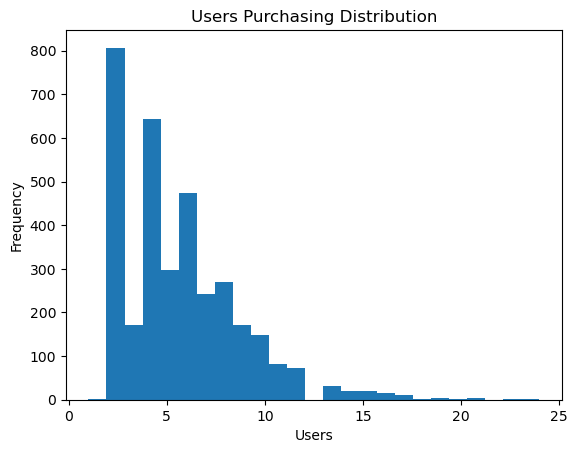

In [12]:
user_purchase_counts = df['User_id'].value_counts()

user_purchase_counts.hist(bins=25)
plt.title('Users Purchasing Distribution')
plt.xlabel('Users')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [13]:
# Top 20 users
user_purchase_counts[:10]

User_id
3247    24
4941    23
1410    21
1169    21
1466    21
3221    20
4272    20
4297    19
1004    19
4683    19
Name: count, dtype: int64

Find average items (total items & unique items) sales / users - for users threshold

In [14]:
df_items_per_users_count = df.groupby('User_id').agg({"itemDescription": ["nunique"]}).reset_index()
df_items_per_users_count.columns = ['User_id', 'unique_items_count']
df_items_per_users_count.head()

,User_id,unique_items_count
0,1000,3
1,1001,5
2,1002,4
3,1003,5
4,1004,15


In [15]:
df_items_per_users_count[df_items_per_users_count['unique_items_count'] == 1]

,User_id,unique_items_count
282,1323,1
405,1463,1
609,1698,1
1321,2527,1
1477,2708,1
1485,2717,1
1639,2889,1
1750,3012,1
1820,3088,1
2317,3671,1


In [16]:
total_unique_items_sales = df_items_per_users_count['unique_items_count'].sum()
total_users = df_items_per_users_count['User_id'].count()

avg_items_sales_per_user = total_unique_items_sales / total_users
print("Total Users: ", total_users)
print("Total Unique Items Sales: ", total_unique_items_sales)
print(f"Average unique items per user: {avg_items_sales_per_user:.2f}")

Total Users:  3493
Total Unique Items Sales:  18288
Average unique items per user: 5.24


Find popularity of item - average users / items

In [17]:
df_users_per_items_count = df.groupby('itemDescription').agg({"User_id": ["nunique"]}).reset_index()
df_users_per_items_count.columns = ['itemDescription', 'unique_users_count']
df_users_per_items_count.head()

,itemDescription,unique_users_count
0,Instant food products,37
1,UHT-milk,165
2,abrasive cleaner,12
3,artif. sweetener,14
4,baby cosmetics,1


In [18]:
total_users_bought = df_users_per_items_count['unique_users_count'].sum()
total_items = df_users_per_items_count['itemDescription'].count()

avg_users_per_item = total_users_bought / total_items
print("Total Items: ", total_items)
print("Total Users Bought: ", total_users_bought)
print(f"Average unique users per item: {avg_users_per_item:.2f}")

Total Items:  167
Total Users Bought:  18288
Average unique users per item: 109.51


Find Average Revisit

In [19]:
df_transaction = pd.DataFrame(df.groupby([df.index, 'User_id'])['itemDescription'].apply(list)).reset_index()
df_transaction.head()

,Date,User_id,itemDescription
0,2014-01-01,1249,"[citrus fruit, coffee]"
1,2014-01-01,1381,"[curd, soda]"
2,2014-01-01,1440,"[other vegetables, yogurt]"
3,2014-01-01,1659,"[specialty chocolate, frozen vegetables]"
4,2014-01-01,1789,"[hamburger meat, candles]"


In [20]:
df_transaction['previous_visit_date'] = df_transaction.groupby('User_id')['Date'].shift(1)

df_revisit = df_transaction[df_transaction['previous_visit_date'].notna()]
df_revisit['previous_visit_date'] = pd.to_datetime(df_transaction['previous_visit_date'])
df_revisit['Date'] = pd.to_datetime(df_transaction['Date'])
df_revisit['revisit_diff'] = (df_revisit['Date'] - df_revisit['previous_visit_date']).dt.days
df_revisit.head()

,Date,User_id,itemDescription,previous_visit_date,revisit_diff
56,2014-01-03,2480,"[other vegetables, salty snack, soda]",2014-01-02,1
135,2014-01-07,1004,"[canned beer, frozen fish]",2014-01-05,2
149,2014-01-07,4721,"[processed cheese, specialty bar]",2014-01-05,2
169,2014-01-08,4933,"[whole milk, root vegetables]",2014-01-02,6
184,2014-01-09,3382,"[candy, tropical fruit, rolls/buns]",2014-01-04,5


In [21]:
df_avg_revisit = df_revisit.groupby('User_id')['revisit_diff'].mean().reset_index()
df_avg_revisit.head()

,User_id,revisit_diff
0,1001,101.000000
1,1002,129.000000
2,1003,134.500000
3,1004,46.833333
4,1005,221.000000


Text(0.5, 1.0, 'Boxplot - Users Revisit Differece Days')

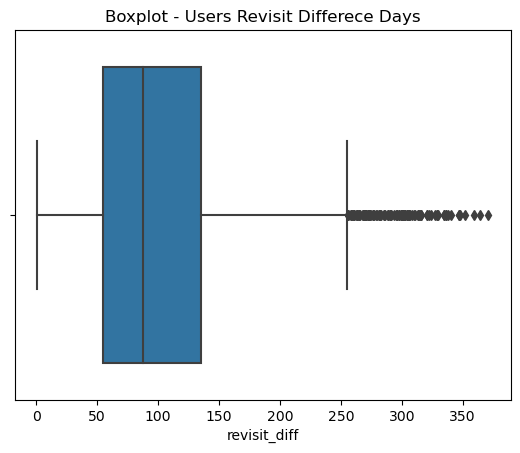

In [22]:
sns.boxplot(x=df_avg_revisit["revisit_diff"])
plt.title("Boxplot - Users Revisit Differece Days")

In [23]:
print(f"Average users revisit days: {np.mean(df_avg_revisit['revisit_diff']):.2f}")

Average users revisit days: 103.59


### Data Preprocessing

In [24]:
df["Date"] = df.index
df_user_items = df.groupby(['User_id', 'itemDescription']).agg({'Date':['count']}).reset_index()
df_user_items.columns = ['User_id', 'itemDescription', 'frequency']
df_user_items.head()

,User_id,itemDescription,frequency
0,1000,pastry,1
1,1000,salty snack,1
2,1000,whole milk,1
3,1001,frankfurter,1
4,1001,rolls/buns,1


In [25]:
# decay_days = (max_date - min_date).days
# print(decay_days)

df['days_ago'] = (max_date - df.index)
df['days_ago'] = df['days_ago'].dt.components.days
# buying patterns paramaters
pattern_days = 365
df['recency_weight'] = np.exp(-df['days_ago'] / pattern_days)
df.head()

,User_id,itemDescription,year,month,day,day_of_week,Date,days_ago,recency_weight
Date,,,,,,,,,
2014-01-01,2351,cleaner,2014,1,1,2,2014-01-01,384,0.349219
2014-01-01,2226,sausage,2014,1,1,2,2014-01-01,384,0.349219
2014-01-01,1922,tropical fruit,2014,1,1,2,2014-01-01,384,0.349219
2014-01-01,2943,whole milk,2014,1,1,2,2014-01-01,384,0.349219
2014-01-01,1249,citrus fruit,2014,1,1,2,2014-01-01,384,0.349219


In [26]:
# Sum weighted counts per user-item
weighted_df = df.groupby(['User_id', 'itemDescription'])['recency_weight'].sum().reset_index()

# Option 1: Multiply frequency × mean recency weight per user-item
df_user_items_recency = df_user_items.merge(weighted_df, on=['User_id', 'itemDescription'])
df_user_items_recency['final_weight'] = df_user_items_recency['frequency'] * df_user_items_recency['recency_weight']
df_user_items_recency

,User_id,itemDescription,frequency,recency_weight,final_weight
0,1000,pastry,1,0.562512,0.562512
1,1000,salty snack,1,0.562512,0.562512
2,1000,whole milk,1,0.562512,0.562512
3,1001,frankfurter,1,1.000000,1.000000
4,1001,rolls/buns,1,0.574977,0.574977
...,...,...,...,...,...
18283,4999,semi-finished bread,1,0.685174,0.685174
18284,5000,bottled beer,1,0.836874,0.836874
18285,5000,fruit/vegetable juice,1,0.683300,0.683300
18286,5000,onions,1,0.683300,0.683300


As our dataset is implicit feedback, it would be logical to assign values to every variable. It is set to 0 when there isn't a purchase on record.

In [27]:
user_items_matrix = df_user_items_recency.pivot(index="User_id", columns="itemDescription", values="final_weight")
user_items_matrix.fillna(0, inplace=True)
user_items_matrix

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
User_id,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.562512,0.0,0.0
1001,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.947277,0.0,0.0
1002,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478554,0.0,0.0
1003,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1004,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.598979,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,0.0,0.64864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4995,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4997,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485155,0.0,0.0


In [28]:
sparse_matrix = csr_matrix(user_items_matrix.values)
print(sparse_matrix[:3])

  (0, 105)	0.5625121946541366
  (0, 128)	0.5625121946541366
  (0, 164)	0.5625121946541366
  (1, 56)	1.0
  (1, 122)	0.5749773343207967
  (1, 130)	0.5749773343207967
  (1, 138)	3.797322154942497
  (1, 164)	2.9472768235840903
  (2, 15)	0.47855396191766536
  (2, 63)	0.6814300707907585
  (2, 102)	0.6814300707907585
  (2, 164)	0.47855396191766536


### Model Implementation

In [29]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

weighted_matrix = bm25_weight(sparse_matrix.T).T

model = AlternatingLeastSquares(factors=50, regularization=0.2, iterations=20, random_state=8)
model.fit(weighted_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
user_mapping = list(user_items_matrix.index)
item_mapping = list(user_items_matrix.columns)

In [31]:
item_mapping[:10]

['Instant food products',
 'UHT-milk',
 'abrasive cleaner',
 'artif. sweetener',
 'baby cosmetics',
 'bags',
 'baking powder',
 'bathroom cleaner',
 'beef',
 'berries']

In [32]:
similar_items = model.similar_items(item_mapping.index('beef'), N=6)

print(f"Item - Score")
similar_items[0]
for index, item_id in enumerate(similar_items[0]):
    if index > 0:
        print(f"{item_mapping[item_id]}: {similar_items[1][index]}")


Item - Score
male cosmetics: 0.3459910750389099
hair spray: 0.32487162947654724
frozen meals: 0.3227373957633972
light bulbs: 0.2586541771888733
flower soil/fertilizer: 0.24513070285320282


In [33]:
def recommend_without_freqset(user_items_matrix, user_id, user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5):

    # user_id index
    user_index = user_mapping.index(user_id)
    recommended = model.recommend(user_index, sparse_matrix[user_index], N=number_of_items)
    # recommended = (array(item), array(score))
    recommended_items = [item_mapping[item_id] for item_id in recommended[0]]
    recommended_score = recommended[1]

    # print(f"Item - Score")
    # for index, item_name in enumerate(recommended_items):
        # print(f"{item_name}: {recommended_score[index]}")

    return recommended_items

In [34]:
def recommend_with_freqset(user_items_matrix, user_id, rules=rules, metrics='lift', user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5):
    # Get items the user recently interacted with
    user_purchased_items = set(df[df['User_id'] == user_id]['itemDescription'].unique().tolist())
    rule_boost = defaultdict(float)
    for _, row in rules.iterrows():
        if set(row['antecedents']).issubset(set(user_purchased_items)):
            for item in row['consequents']:
                rule_boost[item] += row[metrics]  # or use confidence
                
    user_index = user_mapping.index(user_id)

    # top_item can be changed
    top_item=20
    recommended = model.recommend(user_index, sparse_matrix[user_index], N=top_item)
    recommended_top_items = [(item_id, item_mapping[item_id]) for item_id in recommended[0]]
    recommended_score = recommended[1]
    
    final_scores = {}
    for index, item in enumerate(recommended_top_items):
        item_name = item[1]
        boost = rule_boost.get(item_name, 0)
        final_scores[item_name] = recommended_score[index] + boost  # tune this weight if needed

    final_recommendations = sorted(final_scores.items(), key=lambda x: -x[1])[:5]
    final_recommendation_items = []
    # print(f"Item - Score")
    for item_name, score in final_recommendations:
        # print(f"{item_name}: {score}")
        final_recommendation_items.append(item_name)

    return final_recommendation_items

In [35]:
def get_recommendation_items(user_id, with_freq_set=True, numbers_of_items=5):
    if user_id not in set_train_users:
        top_items = df['itemDescription'].value_counts().head(numbers_of_items).index.tolist()
        return top_items
    else:
        if with_freq_set:
            return recommend_with_freqset(user_items_matrix, user_id)
        else:
            return recommend_without_freqset(user_items_matrix, user_id)

### Evaluation

In [36]:
df[df["User_id"] == 2430]

,User_id,itemDescription,year,month,day,day_of_week,Date,days_ago,recency_weight
Date,,,,,,,,,
2014-01-28,2430,pastry,2014,1,28,1,2014-01-28,357,0.376032
2014-01-28,2430,margarine,2014,1,28,1,2014-01-28,357,0.376032
2014-01-28,2430,pastry,2014,1,28,1,2014-01-28,357,0.376032
2014-01-28,2430,pastry,2014,1,28,1,2014-01-28,357,0.376032
2014-03-02,2430,sausage,2014,3,2,6,2014-03-02,324,0.411613
2014-03-02,2430,pastry,2014,3,2,6,2014-03-02,324,0.411613
2015-01-20,2430,fruit/vegetable juice,2015,1,20,1,2015-01-20,0,1.000000
2015-01-20,2430,specialty bar,2015,1,20,1,2015-01-20,0,1.000000


In [37]:
df_test[df_test["User_id"] == 2430]

,User_id,itemDescription,year,month,day,day_of_week
Date,,,,,,
2015-01-20,2430,root vegetables,2015,1,20,1
2015-01-20,2430,sliced cheese,2015,1,20,1
2015-01-20,2430,butter,2015,1,20,1
2015-01-20,2430,chocolate,2015,1,20,1


In [38]:
df_test[df_test["User_id"] == 2430]["itemDescription"].to_list()

['root vegetables', 'sliced cheese', 'butter', 'chocolate']

In [39]:
print("Recommend without freqset: ", get_recommendation_items(2430, False))
print("Recommend with freqset: ",get_recommendation_items(2430))

Recommend without freqset:  ['liver loaf', 'spread cheese', 'pet care', 'kitchen towels', 'salt']
Recommend with freqset:  ['cat food', 'berries', 'liver loaf', 'spread cheese', 'pet care']


1 item - user

In [40]:
df[df["User_id"] == 1323]

,User_id,itemDescription,year,month,day,day_of_week,Date,days_ago,recency_weight
Date,,,,,,,,,
2014-06-18,1323,whole milk,2014,6,18,2,2014-06-18,216,0.553341
2014-06-18,1323,whole milk,2014,6,18,2,2014-06-18,216,0.553341


In [41]:
similar_items = model.similar_items(item_mapping.index('whole milk'), N=6)
for index, item in enumerate(similar_items[0]):
    if index > 0:
        print(item_mapping[item])

whisky
frozen fruits
ready soups
brandy
waffles


In [42]:
print("Recommend without freqset: ", get_recommendation_items(1323, False))
print("Recommend with freqset: ",get_recommendation_items(1323))

Recommend without freqset:  ['sauces', 'frozen fruits', 'waffles', 'liquor (appetizer)', 'brandy']
Recommend with freqset:  ['sauces', 'frozen fruits', 'waffles', 'liquor (appetizer)', 'brandy']


New User

In [43]:
print("Recommend without freqset: ", get_recommendation_items(4118, False))
print("Recommend with freqset: ",get_recommendation_items(4118))

Recommend without freqset:  ['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt']
Recommend with freqset:  ['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt']


### Evaluation Metrics

In [68]:
def ndcg_at_k(recommended_items_list, relevant_items, number_of_items=5):
    dcg = sum(1 / np.log2(i + 2) for i, item in enumerate(recommended_items_list) if item in relevant_items)
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant_items), number_of_items)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# Average Precision (AP) function
def average_precision(recommended_items_list, relevant_items, number_of_items=5):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended_items_list):
        if item in relevant_items:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / min(len(relevant_items), number_of_items)

# Reciprocal Rank (RR) function
def reciprocal_rank(recommended_items_list, relevant_items, number_of_items=5):
    for i, item in enumerate(recommended_items_list):
        if item in relevant_items:
            return 1 / (i + 1)
    return 0

In [69]:
test_relevant_items = set(['pet care', 'spread cheese', 'sliced cheese', 'cling film/bags', 'beef'])
test_recommended_items = ['liver loaf', 'spread cheese', 'pet care', 'kitchen towels', 'salt']

In [70]:
def get_evaluation_results(with_freq_set=False, number_of_items=5):
    ground_truth = df_test.groupby('User_id')['itemDescription'].apply(set).to_dict()

    hit_count = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0
    map_sum = 0
    mrr_sum = 0
    total_users = 0

    for user_id, true_items in ground_truth.items():
        if with_freq_set:
            recommended_items = get_recommendation_items(user_id)
        else:
            recommended_items = get_recommendation_items(user_id, False)

        intersaction_rec_items = set(recommended_items) & true_items

        hits = int(len(intersaction_rec_items) > 0)
        precision = len(intersaction_rec_items) / number_of_items
        recall = len(intersaction_rec_items) / len(true_items)
        ndcg = ndcg_at_k(recommended_items, true_items, number_of_items)
        ap = average_precision(recommended_items, true_items, number_of_items)
        rr = reciprocal_rank(recommended_items, true_items, number_of_items)

        hit_count += hits
        precision_sum += precision
        recall_sum += recall
        ndcg_sum += ndcg
        map_sum += ap
        mrr_sum += rr
        total_users += 1

    # Final metrics
    hit_rate = hit_count / total_users
    precision_at_k = precision_sum / total_users
    recall_at_k = recall_sum / total_users
    f1_at_k = (2*precision_at_k*recall_at_k)/(precision_at_k + recall_at_k)
    ndcg_at_k_score = ndcg_sum / total_users
    map_at_k_score = map_sum / total_users
    mrr_at_k_score = mrr_sum / total_users

    return {
        f'Hit Rate@{number_of_items}': hit_rate,
        f'Precision@{number_of_items}': precision_at_k,
        f'Recall@{number_of_items}': recall_at_k,
        f'f1@{number_of_items}': f1_at_k,
        f'ndcg@{number_of_items}': ndcg_at_k_score,
        f'MAP@{number_of_items}': map_at_k_score,
        f'MRR@{number_of_items}': mrr_at_k_score
    }


In [71]:
evaluation_rec_with_fs = get_evaluation_results(with_freq_set=True)
print("Evaluation Result with frequent data set:\n")
print(evaluation_rec_with_fs)

print("-------------------------------------------")
evaluation_rec_without_fs = get_evaluation_results(with_freq_set=False)
print("Evaluation Result without frequent data set:\n")
print(evaluation_rec_without_fs)

Evaluation Result with frequent data set:

{'Hit Rate@5': 0.230578768183225, 'Precision@5': 0.059052924791085946, 'Recall@5': 0.056099101638216714, 'f1@5': 0.05753812820520347, 'ndcg@5': 0.07072160447145082, 'MAP@5': 0.04192329516145664, 'MRR@5': 0.1297843804807589}
-------------------------------------------
Evaluation Result without frequent data set:

{'Hit Rate@5': 0.22717424945837203, 'Precision@5': 0.058186320024759784, 'Recall@5': 0.055840770437452836, 'f1@5': 0.05698942112671929, 'ndcg@5': 0.06941279144231685, 'MAP@5': 0.041040355583066755, 'MRR@5': 0.12675642216032154}


In [72]:
def plot_metrics(results, title="Recommendation Evaluation Metrics (Top-5)"):
    labels = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(8, 5))
    bars = plt.barh(labels, scores, color='skyblue')
    plt.xlabel('Score')
    plt.title(title)
    plt.xlim(0, 1)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{width:.2f}', va='center')

    plt.tight_layout()
    plt.show()

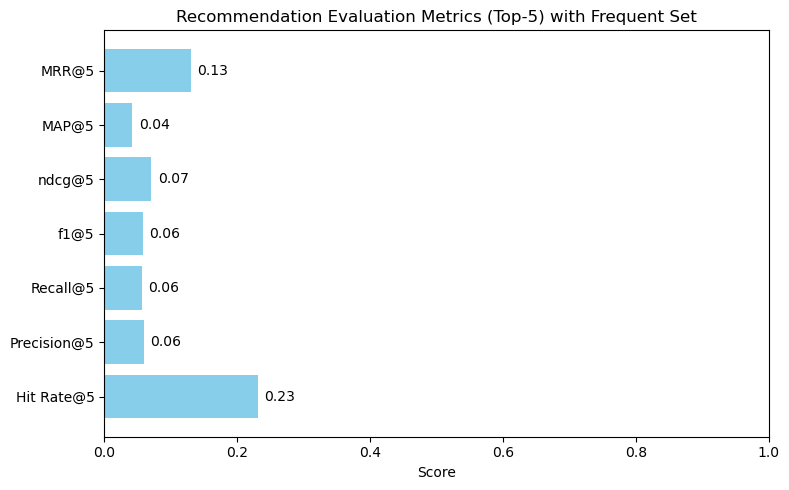

In [73]:
plot_metrics(evaluation_rec_with_fs, "Recommendation Evaluation Metrics (Top-5) with Frequent Set")

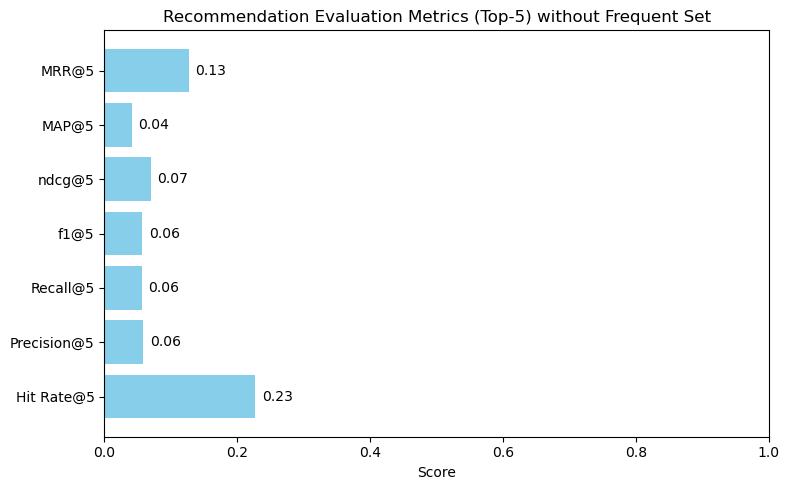

In [74]:
plot_metrics(evaluation_rec_without_fs, "Recommendation Evaluation Metrics (Top-5) without Frequent Set")

### Reflection

**Code Version**: version01

* **Stages**: Analyst, Visualized data, Preprocessed data and Implemented base model
* **Progress & Results**: Performed analysis, reseach collaborative filtering methods and implement the first base model.
* **Reflection**: I learned how to analyze transaction data. During data preprocessing, I found that the user-item matrix had many missing values, so I researched the method of handling them. As the dataset is implicit feedback, the missing value can be treated as zero to indicate that there is zero purchasing on that item (Yifan Hu, Koren, Y & Volinsky, C 2008). The first base model used the AlternatingLeastSquares approach.

**Code Version**: version02

* **Stages**: Implemented recommendation model
* **Progress & Results**: Implemented collaborative filtering with frequency dataset and added recency weight. 
* **Reflection**: One of the assignment requirements indicates that the recommendation items should based on the recency of users purchased. Therefore, I added the recency weight and multiplied it by the quantity for the Users-Items matrix, which will be input for the collaborative filtering model. Then, I learned how to integrate association rules into collaborative filtering. The rules in this code version are dummy, so I couldn't compare the results with/without frequency datasets. I also cleaned the code to function that makes it easier to integrate in task.

**Code Version**: version03

* **Stages**: Analyst and Evaluation recommendation model
* **Progress & Results**: Performed more analysis on users recency and Added evaluation metrics.
* **Reflection**: I added hit rate, precision, recall and f1 score for evaluation metrics. I did some analysis of users' recency; I thought that the revisit pattern might affect the recency weight. I used the exponential decay function for recency weight, which is quite commonly used in several works (Larrain S, Trattner C, Parra D, Graells-Garrido E & Nørvåg, K 2015). This assignment's decay rate or time constant is the revisit days pattern. From analysis, I found that the average revisit days is around 104. I applied this value to check whether it is improved from previous settings, which is 120 days (approximate from the medium-term revisit pattern). However, in the results from several settings, I found that the higher the decay rate, the better the precision and hit rate results.

**Summarize Progress Table** 

| Code Version | Progress & Results                                                                         |
|:-------------|:-------------------------------------------------------------------------------------------|
|version01     |Performed analysis, reseach collaborative filtering methods and implement the first base model.|
|version02     |Implemented collaborative filtering with frequency dataset and added recency weight.|
|version03     |Performed more analysis on users recency and Added evaluation metriccs.|


### References

| Contribution Part | Reference                  |Citation                                                  |
|:------------------|:---------------------------|:---------------------------------------------------------|
|Data Preprocessing|Users & Items Matrix|Zaishan Weng 2023, 'Quick start guide to build a Collaborative Filtering Recommendation System with implicit library in 4 steps', medium, accessed 23 April 2025,<https://medium.com/@zaishanweng/quick-start-guide-to-build-a-collaborative-filtering-recommendation-system-with-implicit-library-in-c5e79e35dfb8>|
|Data Preprocessing|Data Sparse|Yuki Shizuya 2024, 'Detailed explanation about Collaborative filtering with Python examples', medium, accessed 23 April 2025,<https://medium.com/@ichigo.v.gen12/detailed-explanation-about-collaborative-filtering-eab116e3b28b>|
|Data Preprocessing|Recency Weight|Larrain, S, Trattner, C, Parra, D, Graells-Garrido, E & Nørvåg, K 2015, ‘Good Times Bad Times: A Study on Recency Effects in Collaborative Filtering for Social Tagging’, in Proceedings of the 9th ACM Conference on Recommender Systems, ACM, New York, NY, USA, pp. 269–272.|
|Model Implementation|Implicit feedback|Yao-Ting(Teddy) 2019,'Implicit Feedback Recommendation System (II) — Collaborative Filtering', medium, accessed 23 April 2025,<https://medium.com/@teddywang0202/implicit-feedback-recommendation-system-ii-collaborative-filtering-27be600197f1>|
|Model Implementation|Implicit feedback|Yifan Hu, Koren, Y & Volinsky, C 2008, ‘Collaborative Filtering for Implicit Feedback Datasets’, in 2008 Eighth IEEE International Conference on Data Mining, IEEE, pp. 263–272.|
|Model Implementation|Implicit Library|implicit library, https://benfred.github.io/implicit/index.html|
|Model Implementation|OpenAI ChatGPT|OpenAI’s ChatGPT, personal communication, <https://chatgpt.com/>|
|Model Implementation|Association Rules Integration|Lee, C.H., Kim, Y.H. and Rhee, P.K., 2001. Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131-137.|
|Model Implementation|Association Rules Integration|Parvatikar, S. and Joshi, B., 2015, December. Online book recommendation system by using collaborative filtering and association mining. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC) (pp. 1-4).|
|Model Evaluation|Evaluation Metrics|Pratik Aher 2023, 'Evaluation Metrics for Recommendation Systems – An Overview', medium, accessed 26 April 2025,<https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba/>|